Datasets can be downloaded [here](https://www.dropbox.com/sh/2vmlbo7sgf5w26v/AABuNn2MATJ8Tm_mpqPZIcw2a?dl=0)   

Data preparation is illustrated [here](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/prep_nestorowa2016.ipynb)

Ref: Nestorowa, S. et al. A single-cell resolution map of mouse hematopoietic stem and progenitor cell differentiation. Blood 128, e20-31 (2016).

In [2]:
import stream as st
st.__version__

'1.0'

In [3]:
st.set_figure_params(dpi=80,style='white',figsize=[5.4,4.8],
                     rc={'image.cmap': 'viridis'})

#### Read in data

In [4]:
adata=st.read(file_name='./data_nestorowa2016.tsv.gz',workdir='./stream_result')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Saving results in: ./stream_result


> **To load and use 10x Genomics single cell RNA-seq data processed with Cell Ranger:**   
(*The variable index can be reset by choosing a different column in `gene.tsv`*)
```python
adata=st.read(file_name='./filtered_gene_bc_matrices/matrix.mtx',
              file_feature='./filtered_gene_bc_matrices/genes.tsv',
              file_sample='./filtered_gene_bc_matrices/barcodes.tsv',
              file_format='mtx',workdir='./stream_result')    
adata.var.index = adata.var[1].values   
```

> **If the Anndata object is already created, to run STREAM, please simply specify work directory:**
```python
st.set_workdir(adata,'./stream_result')
```

In [5]:
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 1656 × 40594
    uns: 'workdir'

#### Read in metadata

In [7]:
st.add_metadata(adata,file_name='./metadata.tsv')

In [8]:
adata.obs.head()

,label,label_color
HSPC_025,MPP,#eea113
HSPC_031,HSC,#40bdbd
HSPC_037,HSC,#40bdbd
LT-HSC_001,HSC,#40bdbd
HSPC_001,HSC,#40bdbd


> **Alternatively, the step can be divided into two step:**  
(*if `file_name` is not specified, 'unknown' will be genereated for cell label and random color will be used for each label*)
```python
st.add_cell_labels(adata,file_name='./cell_label.tsv.gz')
st.add_cell_colors(adata,file_name='./cell_label_color.tsv.gz')
```

#### Calculate QC

In [9]:
st.cal_qc(adata,assay='rna')

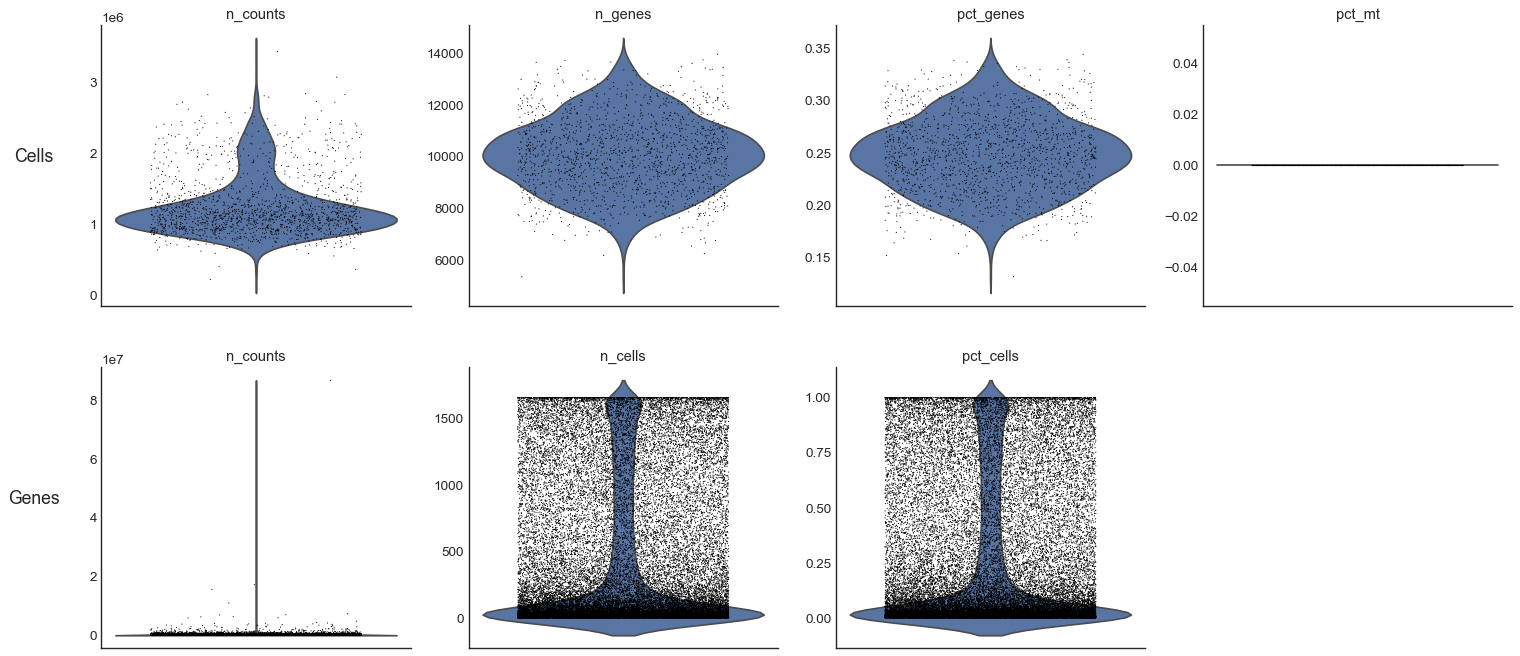

In [10]:
st.plot_qc(adata,jitter=0.3,)

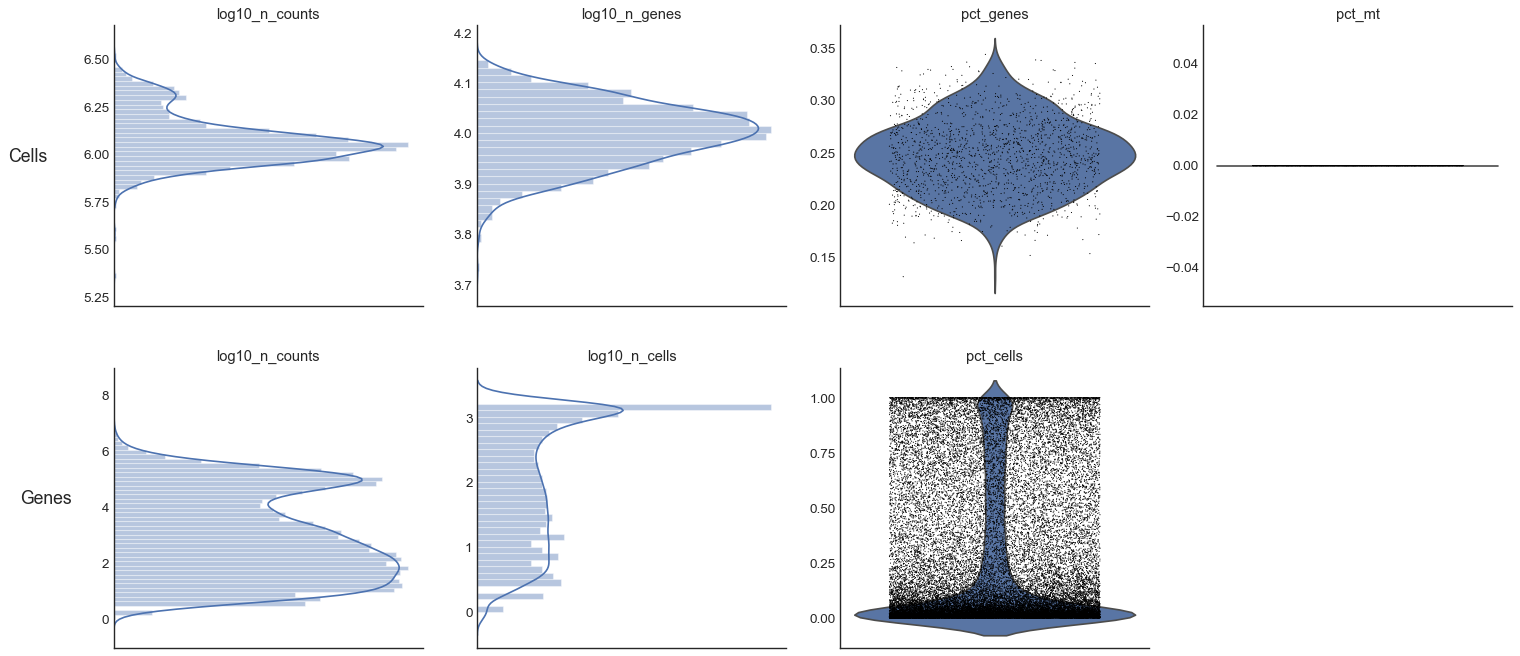

In [11]:
### histogram plots and log-scale are also supported
st.plot_qc(adata,jitter=0.3,log_scale=[0,1,4,5],hist_plot=[0,1,4,5]) 

In [12]:
st.filter_cells(adata,min_n_features= 100)
st.filter_features(adata,min_n_cells = 5)

filter cells based on min_n_features
after filtering out low-quality cells: 
1656 cells, 40594 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
1656 cells, 35077 genes


In [13]:
###Normalize gene expression based on library size  
st.normalize(adata,method='lib_size')
###Logarithmize gene expression 
st.log_transform(adata)
###Remove mitochondrial genes 
st.remove_mt_genes(adata)

#### Feature selection

Please check if the blue curve fits the points well. If not, please adjust the parameter **'loess_frac'** (usually by lowering it) until the blue curve fits well. 

1754 variable genes are selected


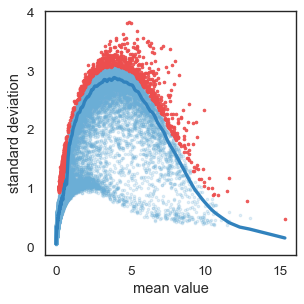

In [14]:
st.select_variable_genes(adata,loess_frac=0.01,percentile=95)

**Alternatively, user can also select top  principal components using all genes or variable genes:**
- use all genes   
`st.select_top_principal_components(adata,n_pc=15,first_pc=True)`
- use variable genes   
    - users need to first run `st.select_variable_genes(adata,loess_frac=0.01, n_genes=2000)`  
    - `st.select_top_principal_components(adata,feature='var_genes',n_pc=40,first_pc=True)`

#### Dimension reduction

In [15]:
st.dimension_reduction(adata,method='se',feature='var_genes',n_components=2,n_neighbors=15,n_jobs=4)

feature var_genes is being used ...
4 cpus are being used ...


> **Alternatively, using top principal components as features:**
`st.dimension_reduction(adata,method='se',feature='top_pcs',n_neighbors=15, n_components=2)`

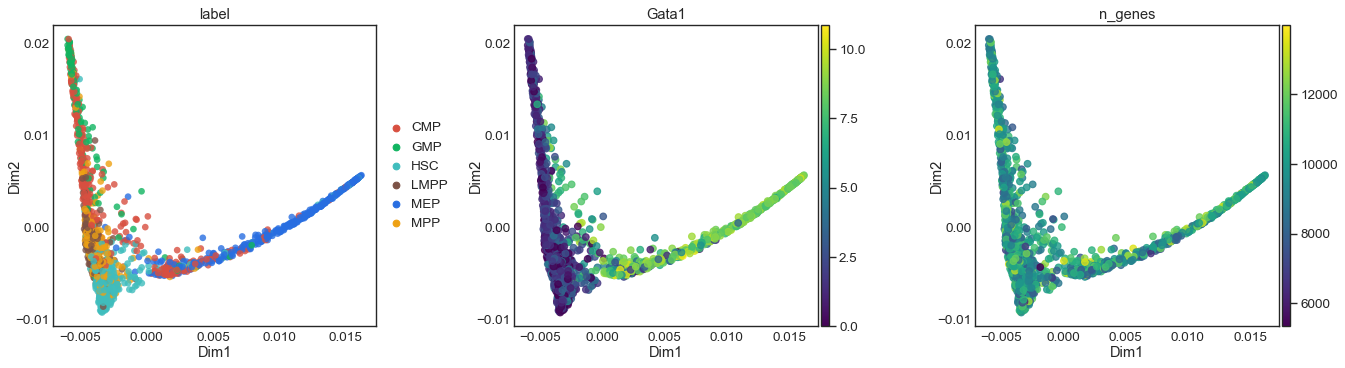

In [16]:
st.plot_dimension_reduction(adata,color=['label','Gata1','n_genes'],
                            n_components=2,show_graph=False,show_text=False)

#### Trajectory inference

In [17]:
st.seed_elastic_principal_graph(adata,n_clusters=10)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3


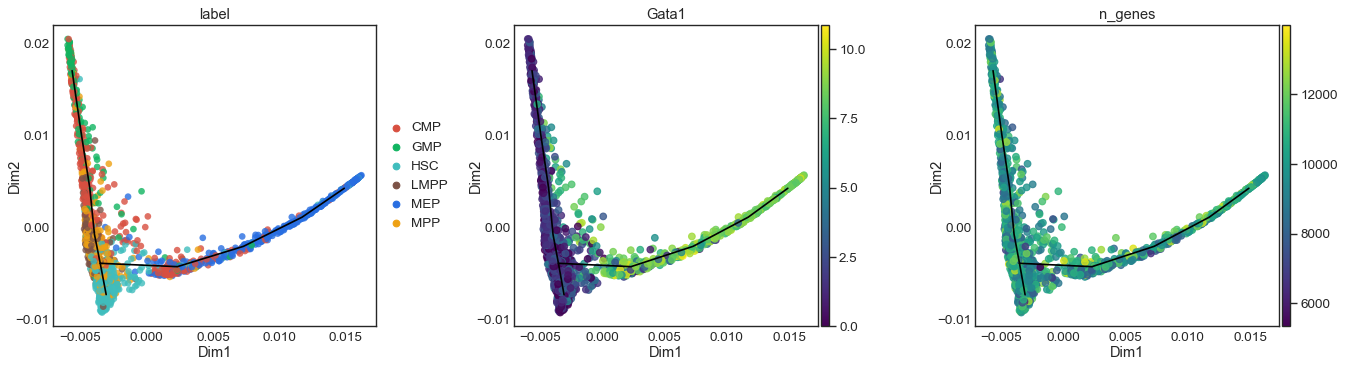

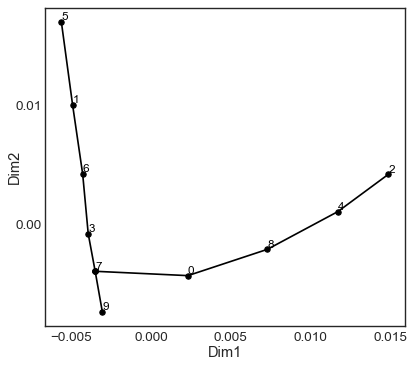

In [18]:
st.plot_dimension_reduction(adata,color=['label','Gata1','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=True)

**`epg_alpha`, `epg_mu`, `epg_lambda` are the three most influential parameters for learning elastic principal graph.**  
- `epg_alpha`: penalizes spurious branching events. **The larger, the fewer branches the function will learn**. (by default, `epg_alpha=0.02`)
- `epg_mu`: penalizes the deviation from harmonic embedding, where harmonicity assumes that each node is the mean of its neighbor nodes. **The larger, the more edges the function will use to fit into points(cells)** (by default, `epg_mu=0.1`) 
- `epg_lambda`: penalizes the total length of edges. **The larger, the 'shorter' curves the function will use to fit into points(cells)** and the fewer points(cells) the curves will reach. (by default, `epg_lambda=0.02`)

> **'epg_trimmingradius'** can help get rid of noisy points (by defalut `epg_trimmingradius=Inf`)   
e.g. `st.elastic_principal_graph(adata,epg_trimmingradius=0.1)`  

In [19]:
st.elastic_principal_graph(adata,epg_alpha=0.01,epg_mu=0.05,epg_lambda=0.05)

Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 1656 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
2.842e-06
	
50
	
49
	
46
	
1
	
0
	
0
	
6.393e-07
	
5.854e-07
	
0.9925
	
0.9932
	
2.137e-06
	
6.559e-08
	
3.279e-06
	
0.000164
	
0


9.544 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3


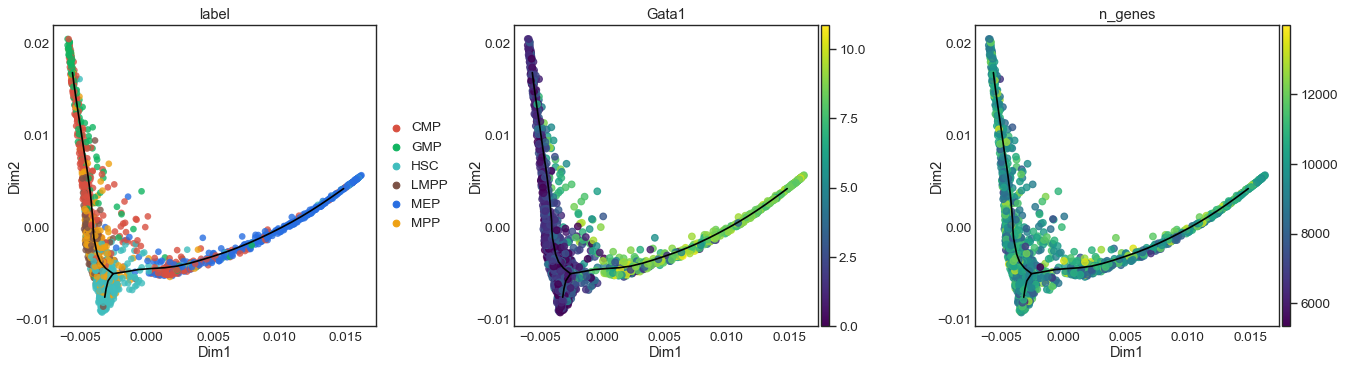

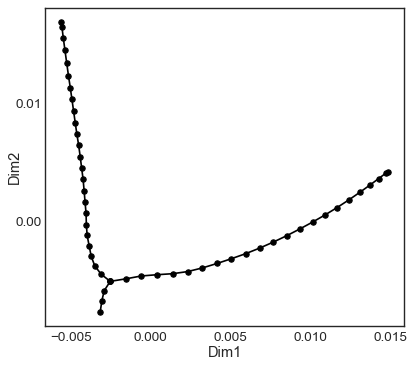

In [20]:
st.plot_dimension_reduction(adata,color=['label','Gata1','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)

#### Adjusting trajectories (optional)

* Finetune branching event:  
```python
st.optimize_branching(adata,incr_n_nodes=30)
st.plot_dimension_reduction(adata,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)
```
* Prune trivial branches:  
```python
st.prune_elastic_principal_graph(adata,epg_collapse_mode='EdgesNumber',epg_collapse_par=2)
st.plot_dimension_reduction(adata,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)
```

* Shift branching node:  
```python
st.shift_branching(adata,epg_shift_mode='NodeDensity',epg_shift_radius=0.1,epg_shift_max=3)
st.plot_dimension_reduction(adata,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)
```

Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


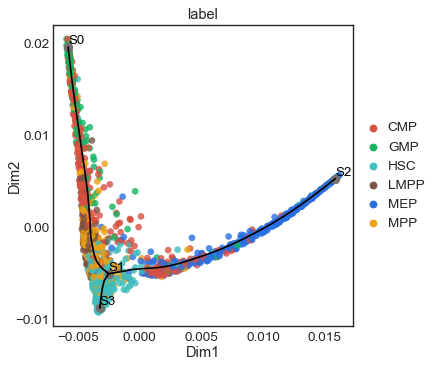

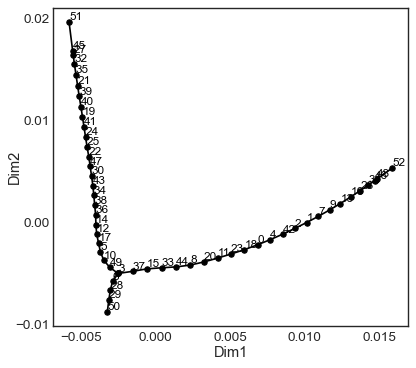

In [21]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['label'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

#### Trajectory visualization

##### flat tree

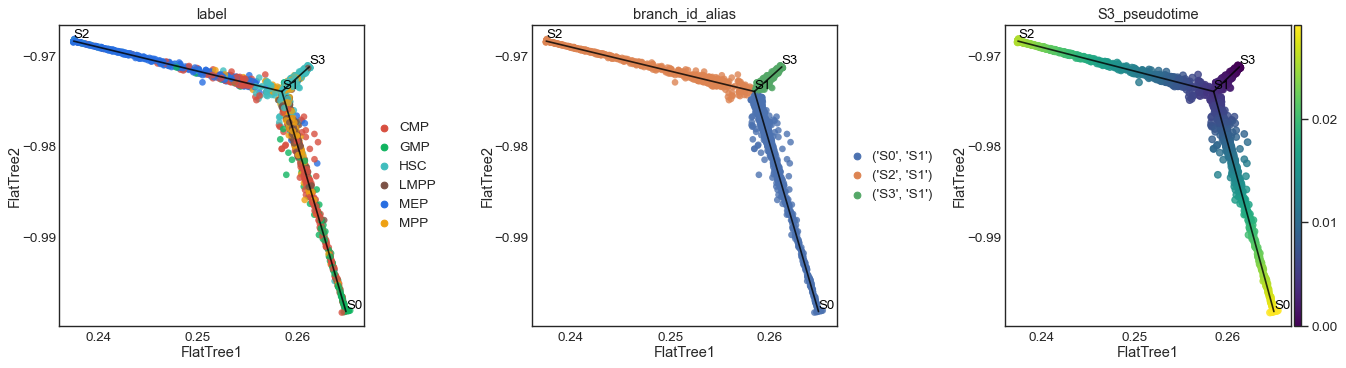

In [22]:
st.plot_flat_tree(adata,color=['label','branch_id_alias','S3_pseudotime'],
                  dist_scale=0.5,show_graph=True,show_text=True)

##### stream plot at single cell level

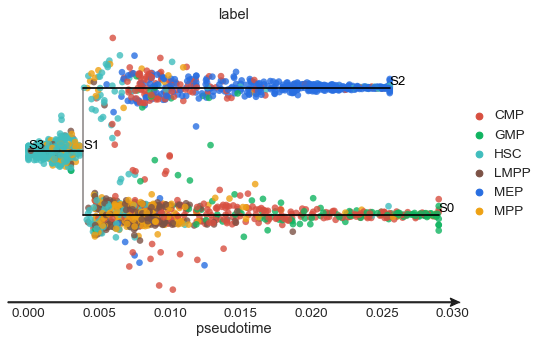

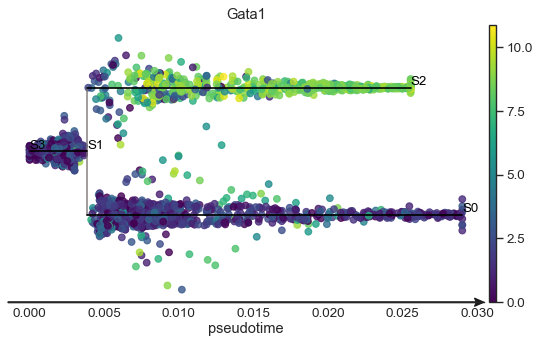

In [23]:
st.plot_stream_sc(adata,root='S3',color=['label','Gata1'],
                  dist_scale=0.3,show_graph=True,show_text=True)

##### stream plots

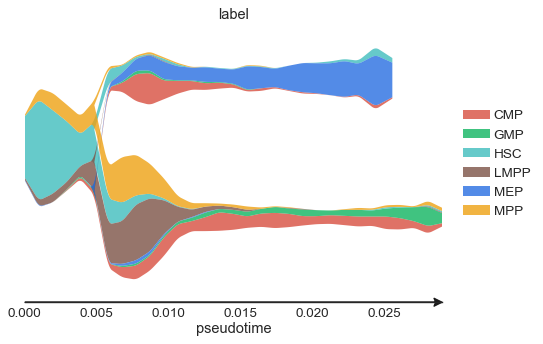

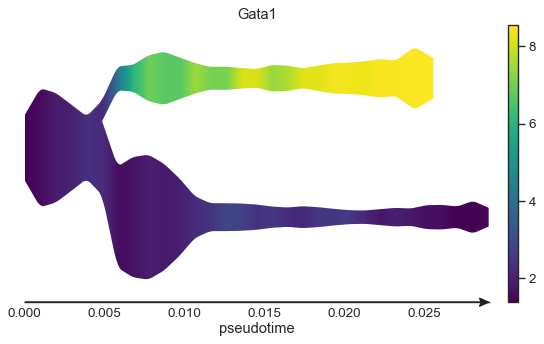

In [24]:
st.plot_stream(adata,root='S3',color=['label','Gata1'])

**Some useful parameters to finetune the appearance of stream plots:**
* `dist_scale`: controls the width of STREAM plot branches.
* `factor_num_win`: controls the resolution of STREAM plot.
* `preference`: controls the order of branches
* `log_scale`: shows stream plot in log scale to zoom in on thin branches

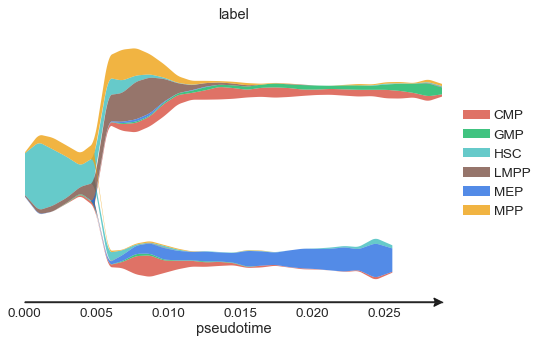

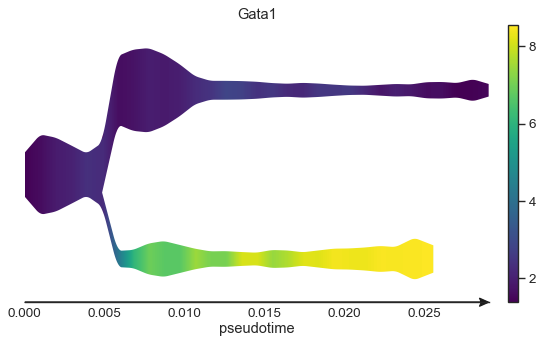

In [25]:
st.plot_stream(adata,root='S3',color=['label','Gata1'],dist_scale=0.5,factor_num_win=1.5,preference=['S0'])

#### Marker genes detection

`marker_list` defines the list of genes to scan. If not specified, by default it uses all available genes. It might be time-consuming.  

Here we only include variable genes.

##### 1) detect marker genes for each leaf branch

In [26]:
st.detect_leaf_markers(adata,marker_list=adata.uns['var_genes'],cutoff_zscore=1.0,cutoff_pvalue=0.01,
                       root='S3',n_jobs=4)

Scanning the specified marker list ...
Filtering out markers that are expressed in less than 5 cells ...
4 cpus are being used ...
1754 markers are being scanned ...


In [27]:
adata.uns['leaf_markers_all'].head()

,zscore,H_statistic,H_pvalue,S3S1_pvalue,S1S2_pvalue,S1S0_pvalue
H2afy,1.40202,1029.39,2.96228e-224,1.61676e-198,4.5081e-317,1
Emb,1.17101,987.714,3.31671e-215,8.25002e-83,0,1
Cd34,1.17922,972.225,7.65782e-212,2.56532e-86,3.78882e-317,1
Mfsd2b,1.41257,938.321,1.76265e-204,2.78863e-209,1,5.62722e-271
Cd53,1.32927,926.336,7.05811e-202,8.37074e-99,7.37407e-290,1


In [28]:
adata.uns['leaf_markers'][('S1','S2')].head()

,zscore,H_statistic,H_pvalue,S3S1_pvalue,S1S2_pvalue,S1S0_pvalue
Mfsd2b,1.41257,938.321,1.76265e-204,2.78863e-209,1,5.62722e-271
Lcp1,-1.41168,838.086,1.02799e-182,1.04374e-144,1,7.64013e-242
Aqp1,1.41421,830.173,5.37295e-181,7.15629e-161,1,5.32332e-230
Gata1,1.41361,829.465,7.65578e-181,1.96117e-162,1,9.52239e-229
Klf1,1.41378,801.407,9.47857e-175,2.91898e-158,1,5.26742e-215


##### 2) detect transition genes for each branch

In [29]:
st.detect_transition_markers(adata,marker_list=adata.uns['var_genes'],cutoff_spearman=0.4,cutoff_logfc=0.25,
                             root='S3',n_jobs=4)

Scanning the specified marker list ...
Importing precomputed scaled marker expression matrix ...
1754 markers are being scanned ...


In [30]:
adata.uns['transition_markers'][('S1','S0')].head()

,stat,logfc,pval,qval
Mpo,0.769028,1.081870,1.365606e-159,1.734320e-156
Plac8,0.761002,0.425997,2.230008e-154,1.416055e-151
Car2,-0.720576,0.864725,5.942962e-131,2.515854e-128
Ctla2a,-0.682847,1.453973,1.494121e-112,4.743834e-110
Ly6a,-0.660810,1.963165,4.852315e-103,1.232488e-100


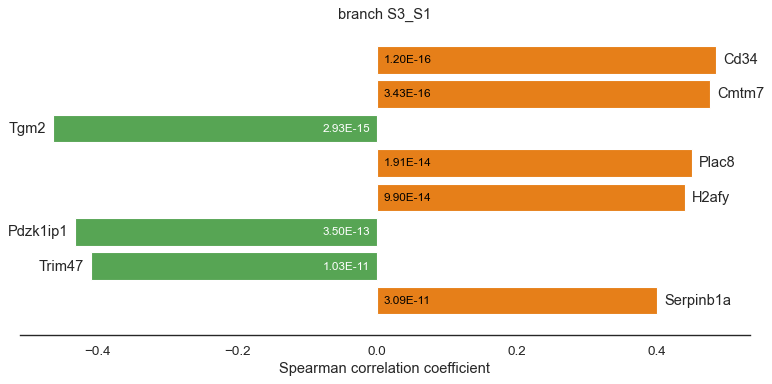

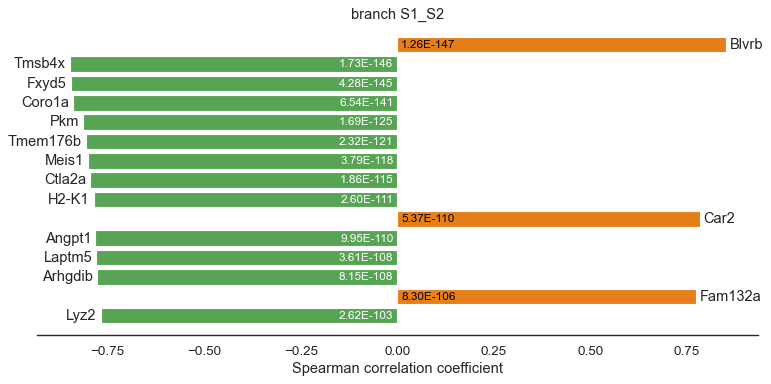

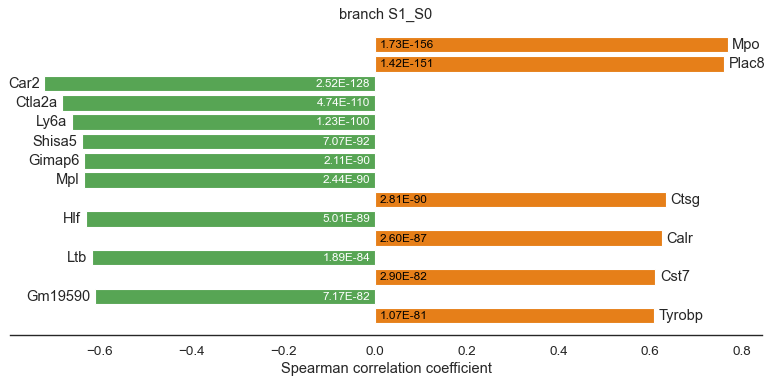

In [31]:
st.plot_transition_markers(adata,fig_size=(10,5))

##### 3) detect marker genes that are differentially expressed between pairs of branches

In [32]:
st.detect_de_markers(adata,marker_list=adata.uns['var_genes'],cutoff_zscore=1,cutoff_logfc=0.25,
                     root='S3',n_jobs=4)

Scanning the specified marker list ...
Importing precomputed scaled marker expression matrix ...
1754 markers are being scanned ...


In [34]:
adata.uns['de_markers_greater'][(('S1', 'S2'), ('S1', 'S0'))].head()

,z_score,U,logfc,mean_up,mean_down,pval,qval
Mfsd2b,28.730380,417884.0,1.697043,0.809967,0.249247,1.596211e-181,5.175713e-179
Aqp1,27.255408,407570.0,1.789395,0.790182,0.228032,1.436631e-163,2.661871e-161
Gata1,26.983410,405600.5,1.890891,0.802041,0.215676,2.318583e-160,3.759003e-158
Klf1,26.588642,402920.0,1.687353,0.806332,0.249806,9.203173e-156,1.326279e-153
Blvrb,25.970485,398611.0,1.198139,0.810328,0.352714,1.069488e-148,1.067020e-146


In [35]:
adata.uns['de_markers_less'][(('S1', 'S2'), ('S1', 'S0'))].head()

,z_score,U,logfc,mean_up,mean_down,pval,qval
Emb,-29.044834,14335.0,1.793693,0.237822,0.826574,1.791976e-185,2.324193e-182
Cd34,-29.008985,14583.5,1.454217,0.317665,0.871946,5.079106e-185,3.293801e-182
H2afy,-28.815991,15934.0,0.453961,0.660631,0.905264,1.355201e-182,5.858988e-180
Cd53,-28.059905,21214.0,2.051684,0.189020,0.786132,3.030388e-173,7.860826e-171
Lcp1,-27.583311,24528.5,1.250045,0.364648,0.868510,1.768029e-167,3.821889e-165


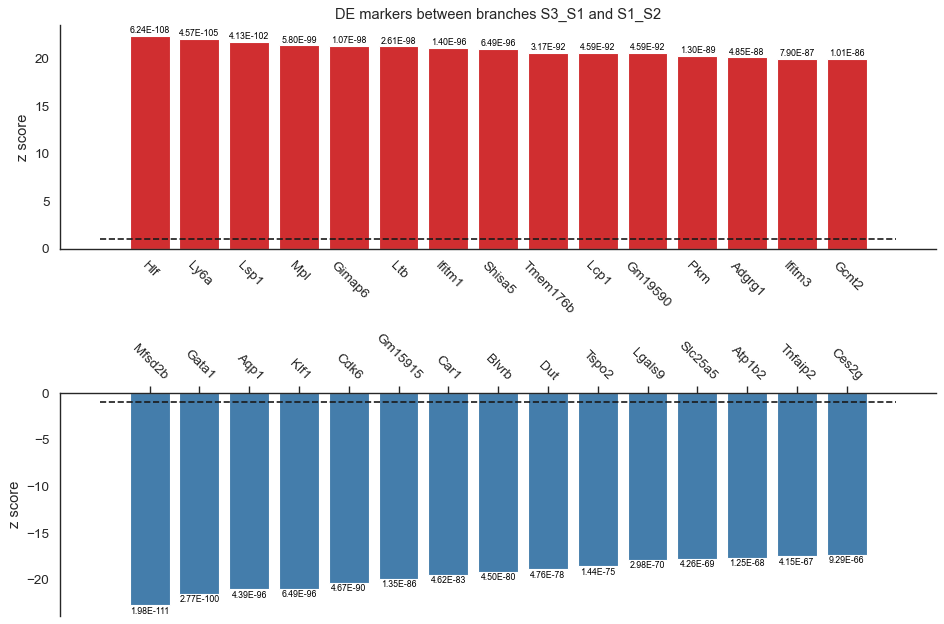

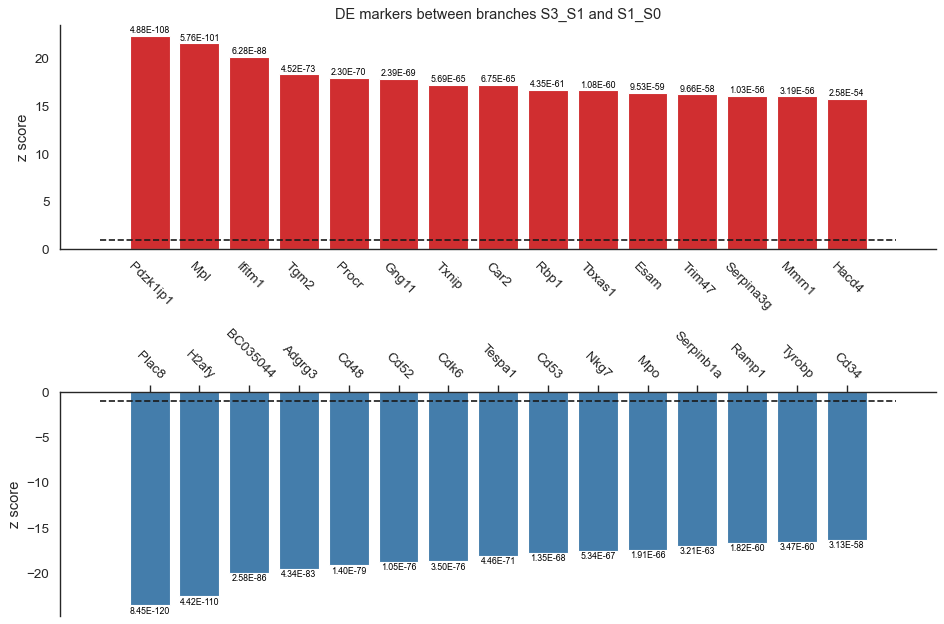

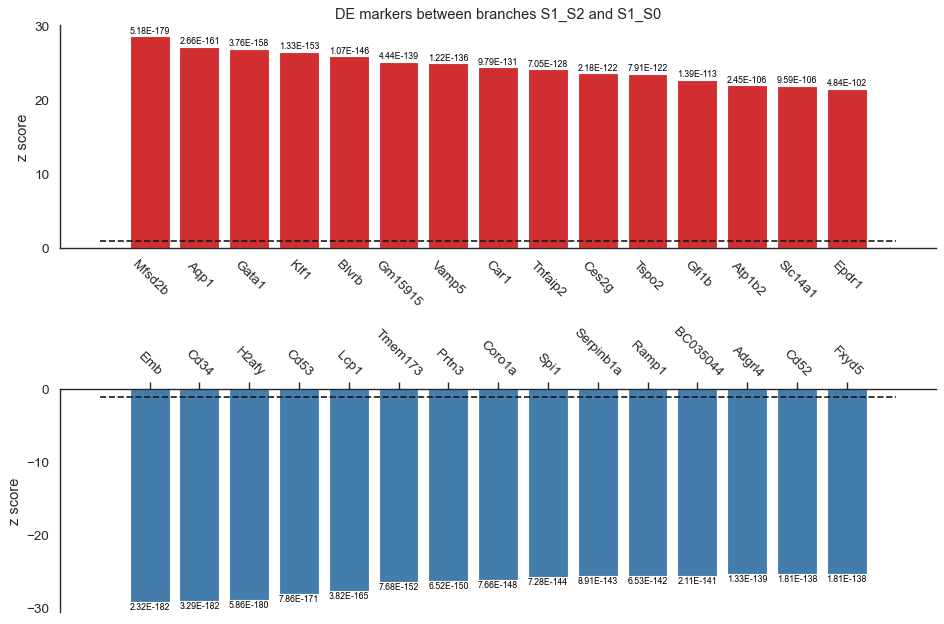

In [36]:
st.plot_de_markers(adata)

##### 4) detect cell population-specific markers

```python
st.detect_markers(adata,ident='label',marker_list=adata.uns['var_genes'],cutoff_zscore=1.0,cutoff_pvalue=0.01)
```

#### Save results

In [37]:
st.write(adata,file_name='stream_result.pkl')

To read back the saved `.pkl` file
```python
adata = st.read('./stream_result/stream_result.pkl')
```